# STAGING LIBRARIES

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# STANDARDIZING DATA

## 1. LOADING CLEANED DATA

In [ ]:
bio_df = pd.read_csv("api_data_aadhar_biometric_cleaned.csv")
demo_df = pd.read_csv("api_data_aadhar_demographic_cleaned.csv")
enrol_df = pd.read_csv("api_data_aadhar_enrolment_cleaned.csv")


## 2. STANDARDIZE COLUMNS

In [ ]:
for df in [bio_df, demo_df, enrol_df]:
    df.columns = df.columns.str.strip().str.lower()
    df["date"] = pd.to_datetime(df["date"], dayfirst=True)
    df["state"] = df["state"].str.strip().str.title()
    df["district"] = df["district"].str.strip().str.title()
    df["pincode"] = df["pincode"].astype(str).str.strip()

## 3. MERGING STANDARDIZED DATASETS

In [ ]:
merge_keys = ["date", "state", "district", "pincode"]
master_df = pd.merge(bio_df, demo_df, on=merge_keys, how="outer")
master_df = pd.merge(master_df, enrol_df, on=merge_keys, how="outer")

## 4. HANDLE MISSING VALUES (DYNAMIC)

In [ ]:
activity_cols = [
    "bio_age_5_17", "bio_age_17_",
    "demo_age_5_17", "demo_age_17_",
    "age_0_5", "age_5_17", "age_18_greater"
]

# keep only columns that actually exist
activity_cols = [c for c in activity_cols if c in master_df.columns]

master_df[activity_cols] = master_df[activity_cols].fillna(0)

## 5. SORT DATA

In [ ]:
master_df = master_df.sort_values(
    by=["state", "district", "pincode", "date"]
).reset_index(drop=True)

## 6. CREATE AGGREGATE METRICS

In [ ]:
master_df["total_bio_updates"] = (
    master_df.get("bio_age_5_17", 0) +
    master_df.get("bio_age_17_", 0)
)

master_df["total_demo_updates"] = (
    master_df.get("demo_age_5_17", 0) +
    master_df.get("demo_age_17_", 0)
)

master_df["total_updates"] = (
    master_df["total_bio_updates"] +
    master_df["total_demo_updates"]
)

master_df["total_enrolments"] = (
    master_df.get("age_0_5", 0) +
    master_df.get("age_5_17", 0) +
    master_df.get("age_18_greater", 0)
)

master_df["total_transactions"] = (
    master_df["total_updates"] +
    master_df["total_enrolments"]
)


## 7. SAVE MASTER DATASET

In [ ]:
master_df.to_csv("aadhaar_master_dataset.csv", index=False)

## 8. QUICK VALIDATION OUTPUT

In [ ]:
print("Master dataset created successfully")
print(master_df.head())
print(master_df.shape)

Master dataset created successfully
        date                        state district pincode  bio_age_5_17  \
0 2025-03-01  Andaman And Nicobar Islands  Nicobar  744301         101.0   
1 2025-04-01  Andaman And Nicobar Islands  Nicobar  744301          28.0   
2 2025-05-01  Andaman And Nicobar Islands  Nicobar  744301          13.0   
3 2025-06-01  Andaman And Nicobar Islands  Nicobar  744301          19.0   
4 2025-07-01  Andaman And Nicobar Islands  Nicobar  744301          23.0   

   bio_age_17_  demo_age_5_17  demo_age_17_  age_0_5  age_5_17  \
0         48.0            0.0           0.0      0.0       0.0   
1         41.0            0.0           0.0      0.0       0.0   
2         15.0            0.0           0.0      0.0       0.0   
3         29.0            0.0           0.0      0.0       0.0   
4         40.0            0.0           0.0      0.0       0.0   

   age_18_greater  total_bio_updates  total_demo_updates  total_updates  \
0             0.0              149.

# AADHAR STRESS INDEX (ASI)

## 1. LOAD MASTER DATA

In [ ]:
df = pd.read_csv("aadhaar_master_dataset.csv")
df["date"] = pd.to_datetime(df["date"])


        date                        state district  pincode  asi_score  \
0 2025-03-01  Andaman And Nicobar Islands  Nicobar   744301  31.905363   
1 2025-04-01  Andaman And Nicobar Islands  Nicobar   744301  37.263141   
2 2025-05-01  Andaman And Nicobar Islands  Nicobar   744301  34.680122   
3 2025-06-01  Andaman And Nicobar Islands  Nicobar   744301  37.561634   
4 2025-07-01  Andaman And Nicobar Islands  Nicobar   744301  39.191914   

  asi_risk  
0   MEDIUM  
1   MEDIUM  
2   MEDIUM  
3   MEDIUM  
4   MEDIUM  


## 2. UPDATE LOAD RATIO (ULR)

In [ ]:

df["ulr"] = df["total_updates"] / (df["total_enrolments"] + 1)


## 3. AGE PRESSURE INDEX (API)

In [ ]:

adult_activity = (
    df.get("bio_age_17_", 0) +
    df.get("demo_age_17_", 0) +
    df.get("age_18_greater", 0)
)

df["api"] = adult_activity / df["total_transactions"]

## 4. SURGE VOLATILITY SCORE (SVS)

In [ ]:
df = df.sort_values(["state", "district", "pincode", "date"])

df["rolling_avg_7d"] = (
    df.groupby(["state", "district", "pincode"])["total_transactions"]
      .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

df["svs"] = df["total_transactions"] / df["rolling_avg_7d"]


## 5. UPDATE INTENSITY FACTOR (UIF)

In [ ]:

df["uif"] = df["total_updates"] / df["total_transactions"]


## 6. NORMALIZATION (0–1 SCALE)

In [ ]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min() + 1e-9)

df["ulr_n"] = normalize(df["ulr"])
df["api_n"] = normalize(df["api"])
df["svs_n"] = normalize(df["svs"])
df["uif_n"] = normalize(df["uif"])


## 7. FINAL ASI SCORE (0–100)

In [ ]:

df["asi_score"] = 100 * (
    0.30 * df["ulr_n"] +
    0.25 * df["api_n"] +
    0.25 * df["svs_n"] +
    0.20 * df["uif_n"]
)


## 8. ASI RISK LABELS

In [ ]:

df["asi_risk"] = pd.cut(
    df["asi_score"],
    bins=[0, 30, 60, 100],
    labels=["LOW", "MEDIUM", "HIGH"]
)


## 9. SAVE OUTPUT

In [ ]:

df.to_csv("aadhaar_asi_output.csv", index=False)


## 10. QUICK CHECK

In [ ]:

print(df[["date", "state", "district", "pincode", "asi_score", "asi_risk"]].head())


# PLOTTING ASI DATA ON GRAPHS

## 1. LOAD ASI OUTPUT DATA

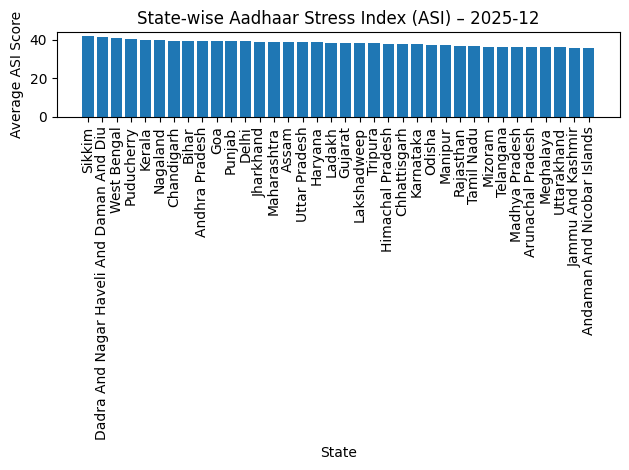

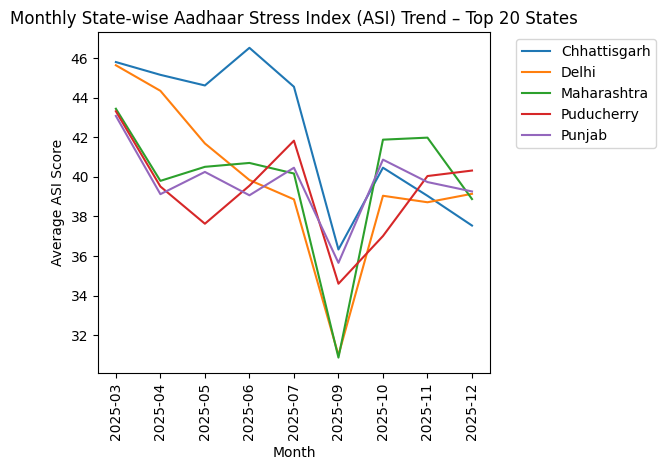

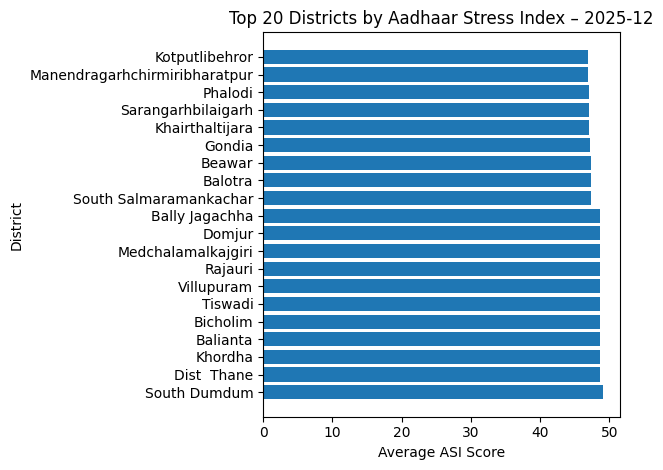

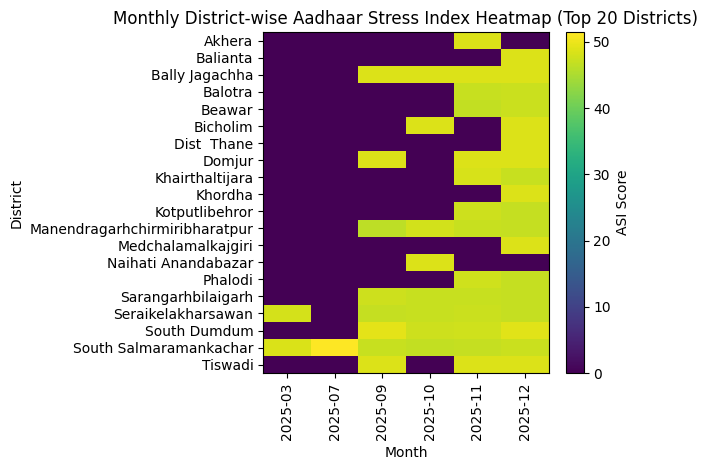

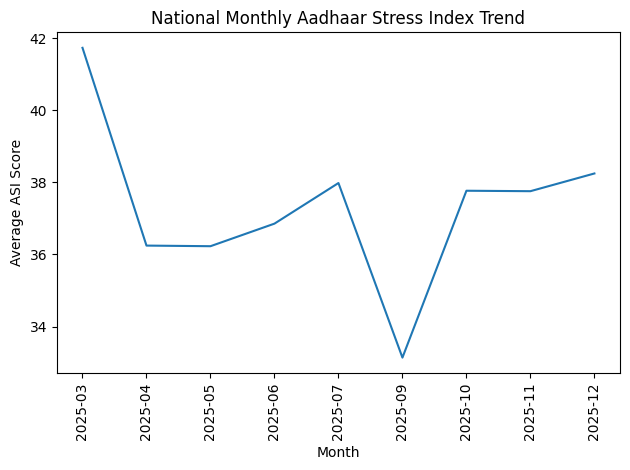

In [ ]:

df = pd.read_csv("aadhaar_asi_output.csv")
df["date"] = pd.to_datetime(df["date"])


## 2. CREATE MONTH COLUMN

In [ ]:

df["month"] = df["date"].dt.to_period("M").astype(str)


## 3. MONTHLY STATE-WISE ASI (BAR PLOT)

In [ ]:

state_monthly_avg = (
    df.groupby(["state", "month"])["asi_score"]
      .mean()
      .reset_index()
)

latest_month = state_monthly_avg["month"].max()
latest_state_asi = (
    state_monthly_avg[state_monthly_avg["month"] == latest_month]
    .sort_values("asi_score", ascending=False)
)

plt.figure()
plt.bar(latest_state_asi["state"], latest_state_asi["asi_score"])
plt.title(f"State-wise Aadhaar Stress Index (ASI) – {latest_month}")
plt.xlabel("State")
plt.ylabel("Average ASI Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 4. MONTHLY STATE-WISE ASI TREND (TOP 20 STATES)

In [ ]:

# Step 1: Identify top 20 states by overall average ASI
top_20_states = (
    state_monthly_avg.groupby("state")["asi_score"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Step 2: Filter data for top 20 states
state_monthly_top20 = state_monthly_avg[
    state_monthly_avg["state"].isin(top_20_states)
]

# Step 3: Plot trend
plt.figure()
for state in state_monthly_top20["state"].unique():
    temp = state_monthly_top20[state_monthly_top20["state"] == state]
    plt.plot(temp["month"], temp["asi_score"], label=state)

plt.title("Monthly State-wise Aadhaar Stress Index (ASI) Trend – Top 20 States")
plt.xlabel("Month")
plt.ylabel("Average ASI Score")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## 5. MONTHLY DISTRICT-WISE ASI (HORIZONTAL BAR)

In [ ]:

district_monthly_avg = (
    df.groupby(["state", "district", "month"])["asi_score"]
      .mean()
      .reset_index()
)

latest_district_asi = (
    district_monthly_avg[district_monthly_avg["month"] == latest_month]
    .sort_values("asi_score", ascending=False)
    .head(20)
)

plt.figure()
plt.barh(
    latest_district_asi["district"],
    latest_district_asi["asi_score"]
)
plt.title(f"Top 20 Districts by Aadhaar Stress Index – {latest_month}")
plt.xlabel("Average ASI Score")
plt.ylabel("District")
plt.tight_layout()
plt.show()


## 6. MONTHLY DISTRICT vs MONTH HEATMAP (TOP 20 DISTRICTS)

In [ ]:

# Step 1: Identify top 20 districts by overall average ASI
top_20_districts = (
    df.groupby("district")["asi_score"]
      .mean()
      .sort_values(ascending=False)
      .head(20)
      .index
)

# Step 2: Filter data for these districts only
df_top20 = df[df["district"].isin(top_20_districts)]

# Step 3: Create heatmap data
district_heatmap = (
    df_top20.groupby(["district", "month"])["asi_score"]
      .mean()
      .unstack(fill_value=0)
)

# Step 4: Plot heatmap
plt.figure()
plt.imshow(district_heatmap, aspect="auto")
plt.colorbar(label="ASI Score")
plt.yticks(
    range(len(district_heatmap.index)),
    district_heatmap.index
)
plt.xticks(
    range(len(district_heatmap.columns)),
    district_heatmap.columns,
    rotation=90
)
plt.title("Monthly District-wise Aadhaar Stress Index Heatmap (Top 20 Districts)")
plt.xlabel("Month")
plt.ylabel("District")
plt.tight_layout()
plt.show()


## 7. OVERALL MONTHLY ASI TREND (NATIONAL VIEW)

In [ ]:

national_monthly = (
    df.groupby("month")["asi_score"]
      .mean()
)

plt.figure()
plt.plot(national_monthly.index, national_monthly.values)
plt.title("National Monthly Aadhaar Stress Index Trend")
plt.xlabel("Month")
plt.ylabel("Average ASI Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# PLOTTING ASI DATA ON MAPS

## 1. GROUP BY STATES, DISTRICT

In [11]:
state_asi = (
    df.groupby("state")["asi_score"]
      .mean()
      .reset_index()
)
district_asi = (
    df.groupby(["state", "district"])["asi_score"]
      .mean()
      .reset_index()
)


## 2. ADDING SHAPE FILE

In [ ]:
states_gdf = gpd.read_file("States\\Admin2.shp")
districts_gdf = gpd.read_file("Districts\\Census_2011\\2011_Dist.shp")


<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
C:\Users\omyad\AppData\Local\Temp\ipykernel_11396\98269707.py:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
  states_gdf = gpd.read_file("States\Admin2.shp")
C:\Users\omyad\AppData\Local\Temp\ipykernel_11396\98269707.py:6: SyntaxWarning: "\C" is an invalid escape sequence. Such seque

In [13]:
print(states_gdf.columns)
print(districts_gdf.columns)


Index(['ST_NM', 'geometry'], dtype='object')
Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')


## 3. MAPPING STATES AND DISTRICT

In [15]:
states_map = states_gdf.merge(
    state_asi,
    left_on="ST_NM",
    right_on="state",
    how="left"
)


In [16]:
districts_map = districts_gdf.merge(
    district_asi,
    left_on=["ST_NM", "DISTRICT"],
    right_on=["state", "district"],
    how="left"
)


## 4. FILLING EMPTY VALUE WITH "0"

In [17]:
states_map["asi_score"] = states_map["asi_score"].fillna(0)
districts_map["asi_score"] = districts_map["asi_score"].fillna(0)


## 5. PLOTING STATE MAP

<Figure size 1200x1200 with 0 Axes>

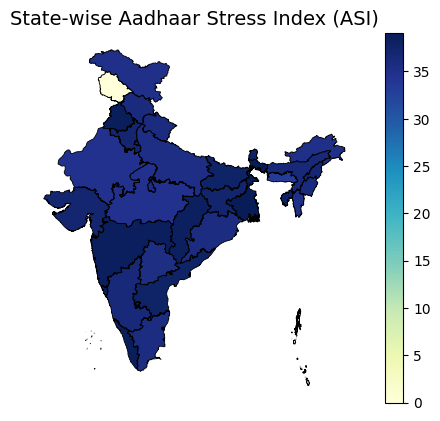

In [23]:
plt.figure(figsize=(12, 12))
states_map.plot(
    column="asi_score",
    cmap="YlGnBu",
    linewidth=0.6,
    edgecolor="black",
    legend=True
)

plt.title("State-wise Aadhaar Stress Index (ASI)", fontsize=14)
plt.axis("off")
plt.show()


## 6. PLOTTING DISTRICT MAP

<Figure size 1400x1400 with 0 Axes>

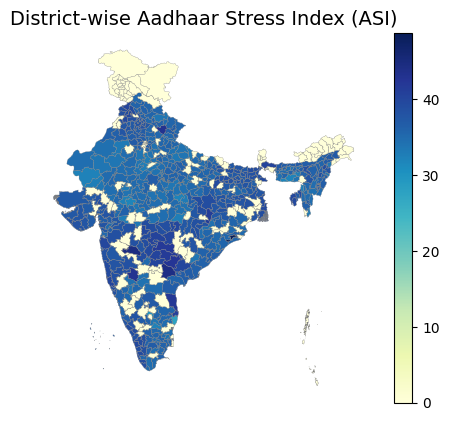

In [24]:
plt.figure(figsize=(14, 14))
districts_map.plot(
    column="asi_score",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True
)

plt.title("District-wise Aadhaar Stress Index (ASI)", fontsize=14)
plt.axis("off")
plt.show()


## 7. PLOTTING TOP 100 DISTRICT

<Figure size 1400x1400 with 0 Axes>

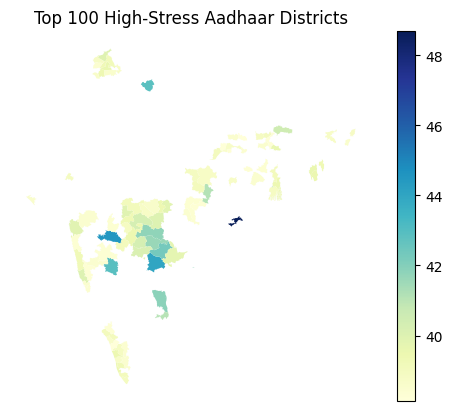

In [25]:
top_districts = districts_map.sort_values(
    "asi_score", ascending=False
).head(100)

plt.figure(figsize=(14, 14))
top_districts.plot(
    column="asi_score",
    cmap="YlGnBu",
    linewidth=0.2,
    legend=True
)

plt.title("Top 100 High-Stress Aadhaar Districts")
plt.axis("off")
plt.show()
